In [ ]:
# install https://github.com/MarkusHaak/dlomix/ with pip
# OR uncomment to insert its path with sys:
#import os, sys
#sys.path.insert(0, os.path.abspath('../../dlomix/'))

In [ ]:
# set global seeds for reproducibility
from dlomix.utils import set_global_seed
set_global_seed(42)

In [54]:
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from dlomix.data import RetentionTimeDataset
from dlomix.models import PrositRetentionTimePredictor
from dlomix.reports import RetentionTimeReport

In [ ]:
# alphabet using the same PTM identifiers as in the created datasets
ALPHABET_MOD = {
    "A": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "H": 7,
    "I": 8,
    "K": 9,
    "L": 10,
    "M": 11,
    "N": 12,
    "P": 13,
    "Q": 14,
    "R": 15,
    "S": 16,
    "T": 17,
    "V": 18,
    "W": 19,
    "Y": 20,
    "^": 21,
    "}": 22,
}

# load conformalized results from QR and MCD

In [58]:
import pickle

In [59]:
all_res = {}

In [60]:
with open("../data/QR_results_cv_with_rnd.pkl", 'rb') as f:
    all_res.update(pickle.load(f))

In [61]:
with open("../data/MonteCarloDropout_results_with_rnd.pkl", 'rb') as f:
    all_res.update(pickle.load(f))

# load test data

In [66]:
TEST_DATAPATH = '../data/PROSPECT_median_holdout_cv.csv'
BATCH_SIZE = 256
test_rtdata = RetentionTimeDataset(data_source=TEST_DATAPATH,
                                   seq_length=30, batch_size=BATCH_SIZE, test=True,
                                   sequence_col='modified_sequence_single_letter',
                                   target_col='median')

In [67]:
test_targets = test_rtdata.get_split_targets(split="test")

In [68]:
TEST_DATAPATH = '../data/PROSPECT_sel10_holdout_cv.csv'
BATCH_SIZE = 256
test_rtdata_sel10 = RetentionTimeDataset(data_source=TEST_DATAPATH,
                                   seq_length=30, batch_size=BATCH_SIZE, test=True,
                                   sequence_col='modified_sequence_single_letter',
                                   target_col='indexed_retention_time')

In [69]:
test_targets_sel10 = test_rtdata_sel10.get_split_targets(split="test")

# load and visualize additional test data statistics

In [70]:
test_data_stats = pd.read_csv('../data/PROSPECT_median_holdout_cv.csv')
# drop long seqs (as it is done when loading datasets with dlomix)
test_data_stats = test_data_stats.loc[test_data_stats.modified_sequence_single_letter.str.len() <= 30].reset_index()
test_data_stats

,index,Unnamed: 0,modified_sequence_single_letter,cnt,std,median,mean,min,max,skew,npstd,set
0,0,645508,G^ILDLQVNNK,35,0.306989,62.685813,62.676850,61.863402,63.115583,-0.907999,0.302572,holdout
1,1,645509,NVVA^ESIGR,46,1.122386,23.426500,23.903623,23.055908,26.817065,1.653995,1.110119,holdout
2,2,645510,YAEQISVLK,105,2.786056,49.190646,47.723419,43.072013,50.052462,-0.968371,2.772757,holdout
3,3,645511,YEDFGPLFTAK,115,0.907778,79.370320,79.301097,76.117981,83.878432,-0.392391,0.903822,holdout
4,4,645512,YAELDREDDF^EAAEAPDIQPK,42,0.225632,57.080780,57.048591,56.164420,57.364063,-2.788328,0.222929,holdout
...,...,...,...,...,...,...,...,...,...,...,...,...
113722,113909,759417,VAVVPKIFYV,1,NaN,98.477712,98.477712,98.477712,98.477712,0.000000,0.000000,holdout
113723,113910,759418,ISIPYVDFFEDPSSERK,43,0.214921,95.828816,95.882884,95.358070,96.419906,0.366729,0.212408,holdout
113724,113911,759419,RDMDII}KL,8,0.111720,58.922257,58.917329,58.731930,59.107046,0.018494,0.104505,holdout
113725,113912,759420,ISISDLEMRQALK,24,0.149828,66.912115,66.952417,66.710872,67.212248,0.187519,0.146673,holdout


In [71]:
# check that test stats are associated with correct data
assert np.allclose(test_data_stats['median'] - test_targets, 0.), "target stats data does not match test_targets"

In [72]:
test_data_stats_sel10 = pd.read_csv('../data/PROSPECT_sel10_holdout_cv.csv')
# drop long seqs (as it is done when loading datasets with dlomix)
test_data_stats_sel10 = test_data_stats_sel10.loc[test_data_stats_sel10.modified_sequence_single_letter.str.len() <= 30].reset_index()
test_data_stats_sel10

,index,Unnamed: 0,modified_sequence_single_letter,indexed_retention_time,andromeda_score
0,0,34644697,AHAAAAALYGGATD,33.714555,78.903
1,1,34644698,PQSGWQFLRGPQQDPGPLR,68.168820,100.710
2,2,34644710,T}TDVVGNPEEERR,13.850960,119.960
3,3,34644714,QWSVFGKTL^R,61.876894,84.479
4,4,34644720,LAPMTREEFLER,48.094482,90.793
...,...,...,...,...,...
996776,998063,40754626,PSVNADEEVGGPQI^RV^GDK,37.147356,109.770
996777,998064,40754627,KEPHWLFGTMERYL,82.925180,75.483
996778,998065,40754654,FQESSPR,1.957686,72.230
996779,998066,40754657,KDELLNIAK,42.285038,153.100


In [73]:
mean_andromeda = test_data_stats_sel10.groupby('modified_sequence_single_letter')[['andromeda_score']].agg('mean')
d_ = test_data_stats.set_index('modified_sequence_single_letter')
d_['mean_andromeda'] = mean_andromeda
test_data_stats = d_.reset_index(drop=False)
test_data_stats

,modified_sequence_single_letter,index,Unnamed: 0,cnt,std,median,mean,min,max,skew,npstd,set,mean_andromeda
0,G^ILDLQVNNK,0,645508,35,0.306989,62.685813,62.676850,61.863402,63.115583,-0.907999,0.302572,holdout,148.7677
1,NVVA^ESIGR,1,645509,46,1.122386,23.426500,23.903623,23.055908,26.817065,1.653995,1.110119,holdout,130.2777
2,YAEQISVLK,2,645510,105,2.786056,49.190646,47.723419,43.072013,50.052462,-0.968371,2.772757,holdout,130.3908
3,YEDFGPLFTAK,3,645511,115,0.907778,79.370320,79.301097,76.117981,83.878432,-0.392391,0.903822,holdout,139.8299
4,YAELDREDDF^EAAEAPDIQPK,4,645512,42,0.225632,57.080780,57.048591,56.164420,57.364063,-2.788328,0.222929,holdout,108.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113722,VAVVPKIFYV,113909,759417,1,NaN,98.477712,98.477712,98.477712,98.477712,0.000000,0.000000,holdout,82.7500
113723,ISIPYVDFFEDPSSERK,113910,759418,43,0.214921,95.828816,95.882884,95.358070,96.419906,0.366729,0.212408,holdout,110.4258
113724,RDMDII}KL,113911,759419,8,0.111720,58.922257,58.917329,58.731930,59.107046,0.018494,0.104505,holdout,83.9515
113725,ISISDLEMRQALK,113912,759420,24,0.149828,66.912115,66.952417,66.710872,67.212248,0.187519,0.146673,holdout,97.4509


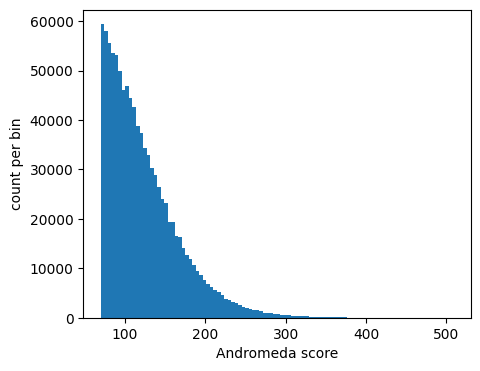

In [74]:
fig,ax = plt.subplots(figsize=(5,4))
ax.hist(test_data_stats_sel10.andromeda_score, bins=100)
ax.set(xlabel="Andromeda score", ylabel="count per bin")
plt.savefig("plots/andromeda.png", dpi=300, bbox_inches='tight')
plt.show()

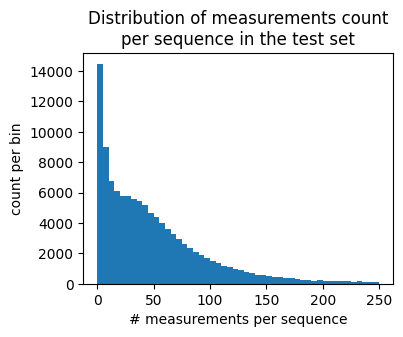

In [75]:
fig,ax = plt.subplots(figsize=(4,3))
ax.hist(test_data_stats.cnt, bins=50, range=(0,250))
ax.set(title="Distribution of measurements count\nper sequence in the test set", xlabel="# measurements per sequence", ylabel="count per bin")
plt.savefig("plots/cnt_dist.png", dpi=300, bbox_inches='tight')
plt.show()

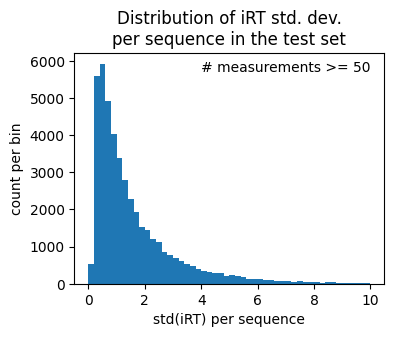

In [76]:
fig,ax = plt.subplots(figsize=(4,3))
ax.hist(test_data_stats.loc[test_data_stats.cnt >= 50, 'std'], bins=50, range=(0,10))
ax.set(title="Distribution of iRT std. dev.\nper sequence in the test set", xlabel="std(iRT) per sequence", ylabel="count per bin")
ax.text(10,6000,"# measurements >= 50",va="top",ha="right")
plt.savefig("plots/std_dist.png", dpi=300, bbox_inches='tight')
plt.show()

# load baseline models & do baseline predictions

In [77]:
import pickle
if os.path.exists('../data/baseline_predictions.pkl'):
    with open('../data/baseline_predictions.pkl', 'rb') as f:
        baseline_predictions = pickle.load(f)
else:
    baseline_predictions = {'median':{'median':{}, 'sel10':{}}, 'sel10':{'median':{}, 'sel10':{}}}
    for cv in range(1,6):
        base_model_sel10 = PrositRetentionTimePredictor(seq_length=30, vocab_dict=ALPHABET_MOD)
        base_model_sel10.load_weights(f"./output_sel10/cv{cv}/best")
        base_model_median = PrositRetentionTimePredictor(seq_length=30, vocab_dict=ALPHABET_MOD)
        base_model_median.load_weights(f"./output_median/cv{cv}/best")
        for l,data in [('median', test_rtdata.test_data),('sel10', test_rtdata_sel10.test_data)]:
            baseline_predictions['sel10'][l][cv] = base_model_sel10.predict(data).ravel()
            baseline_predictions['median'][l][cv] = base_model_median.predict(data).ravel()
    with open('baseline_predictions.pkl', 'wb') as f:
        pickle.dump(baseline_predictions, f)

## compute TimeDeltaMetrics

In [79]:
from dlomix.eval import TimeDeltaMetric
import tensorflow as tf
from sklearn.metrics import r2_score

In [81]:
for ds in ['median','sel10']:
    for testset, targets in [('median', test_targets), ('sel10', test_targets_sel10)]:
        tdms = []
        for cv in range(1,6):
            tdm = TimeDeltaMetric()
            tdm.update_state(tf.constant(baseline_predictions[ds][testset][cv], dtype=tf.float32), tf.constant(targets, dtype=tf.float32))
            tdms.append(tdm.result().numpy())
        print(ds, 'training,', testset, 'test data :', np.mean(tdms), np.std(tdms))

median training, median test data : 5.8074236 0.14502506
median training, sel10 test data : 6.5276136 0.13797112
sel10 training, median test data : 5.9480853 0.05607503
sel10 training, sel10 test data : 6.5851316 0.051938303


## compute R^2 

In [82]:
for ds in ['median','sel10']:
    for testset, targets in [('median', test_targets), ('sel10', test_targets_sel10)]:
        r2s = []
        for cv in range(1,6):
            r2 = r2_score(baseline_predictions[ds][testset][cv], targets)
            r2s.append(r2)
        print(ds, 'training,', testset, 'test data :', np.mean(r2s), np.std(r2s))

median training, median test data : 0.9714507683565182 0.0004509101495511368
median training, sel10 test data : 0.9687349658785948 0.0004514468642170501
sel10 training, median test data : 0.9726549342760826 0.00030402681876247676
sel10 training, sel10 test data : 0.9703399647392141 0.0001820670628350841


# check if baseline predictions lie within intervals

## median

In [83]:
for label in all_res:
    if 'med' in label:
        pred = baseline_predictions['median']['median']
    else:
        pred = baseline_predictions['sel10']['median']
    fracs = []
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        within = (pred[cv] >= intervals[:,0]) & (pred[cv] <= intervals[:,1])
        fracs.append(np.sum(within) / len(within))
    print(f"{label:<29} : {np.mean(fracs) *100:7.2f} +- {np.std(fracs)*100:4.2f} of original pred. are inside intervals")

PRT_med_<-1>:2                :  100.00 +- 0.00 of original pred. are inside intervals
PRT_med_<-1>:64:2             :  100.00 +- 0.00 of original pred. are inside intervals
PRT_med_<-2>:<-1>:2           :   99.98 +- 0.01 of original pred. are inside intervals
PRT_med_:2                    :   88.85 +- 0.88 of original pred. are inside intervals
PRT_sel10_<-1>:2              :  100.00 +- 0.00 of original pred. are inside intervals
PRT_sel10_<-1>:64:2           :   99.98 +- 0.02 of original pred. are inside intervals
PRT_sel10_<-2>:<-1>:2         :   99.89 +- 0.10 of original pred. are inside intervals
PRT_sel10_:2                  :   91.37 +- 1.70 of original pred. are inside intervals
PRT_med_n=3                   :   98.03 +- 0.17 of original pred. are inside intervals
PRT_med_n=5                   :   99.57 +- 0.05 of original pred. are inside intervals
PRT_med_n=10                  :   99.97 +- 0.01 of original pred. are inside intervals
PRT_med_n=20                  :  100.00 +- 

## difference between MCD mean and original pred and targets

In [84]:
all_res['PRT_med_n=100'][1]['data'][0]

array([59.122   , 23.876396, 45.926674, ..., 58.419388, 65.3681  ,
       18.41001 ], dtype=float32)

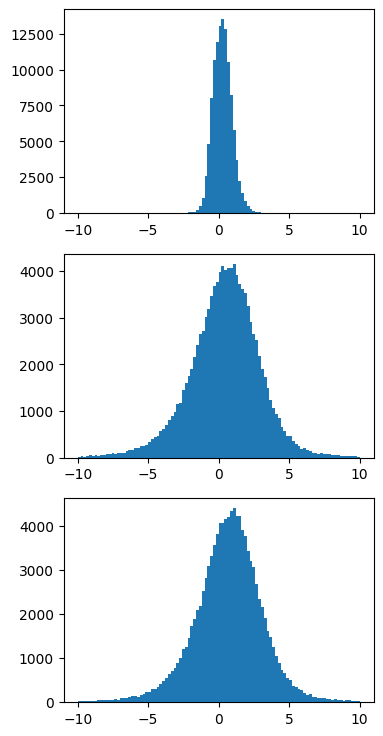

In [85]:
fig,(ax0,ax1,ax2) = plt.subplots(3,1, figsize=(4,9))
origs = baseline_predictions['median']['median'][1]
means = all_res['PRT_med_n=100'][1]['data'][0]
truth = test_targets
ax0.hist(origs - means, bins=100, range=(-10,10))
ax1.hist(truth - origs, bins=100, range=(-10,10))
ax2.hist(truth - means, bins=100, range=(-10,10))
for ax in (ax0,ax1,ax2):
    ax.set()
plt.show()

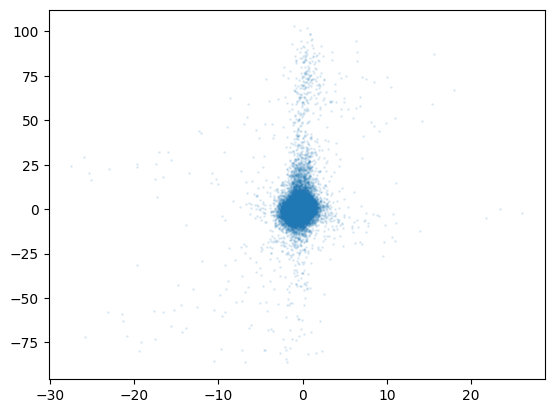

In [86]:
fig,ax = plt.subplots()
ax.scatter(means - origs, truth - origs, s=1., alpha=0.1)

# check marginal coverage

## on median targets

In [87]:
data = []
n = 0
for label in all_res:
    for cv in range(1,6):
        n += 1
        val = np.sum(all_res[label][cv]['within']) / len(all_res[label][cv]['within'])
        data.append(val)
        print(f"{label:<29} {cv} : {val:.2f} marginal coverage")
        val = np.sum(all_res[label][cv]['rnd_within']) / len(all_res[label][cv]['rnd_within'])
        data.append(val)
        print(f"{label + ' rnd':<29} {cv} : {val:.2f} marginal coverage")
print(n)

PRT_med_<-1>:2                1 : 0.90 marginal coverage
PRT_med_<-1>:2 rnd            1 : 0.90 marginal coverage
PRT_med_<-1>:2                2 : 0.90 marginal coverage
PRT_med_<-1>:2 rnd            2 : 0.90 marginal coverage
PRT_med_<-1>:2                3 : 0.90 marginal coverage
PRT_med_<-1>:2 rnd            3 : 0.90 marginal coverage
PRT_med_<-1>:2                4 : 0.90 marginal coverage
PRT_med_<-1>:2 rnd            4 : 0.90 marginal coverage
PRT_med_<-1>:2                5 : 0.90 marginal coverage
PRT_med_<-1>:2 rnd            5 : 0.90 marginal coverage
PRT_med_<-1>:64:2             1 : 0.90 marginal coverage
PRT_med_<-1>:64:2 rnd         1 : 0.90 marginal coverage
PRT_med_<-1>:64:2             2 : 0.90 marginal coverage
PRT_med_<-1>:64:2 rnd         2 : 0.90 marginal coverage
PRT_med_<-1>:64:2             3 : 0.90 marginal coverage
PRT_med_<-1>:64:2 rnd         3 : 0.90 marginal coverage
PRT_med_<-1>:64:2             4 : 0.90 marginal coverage
PRT_med_<-1>:64:2 rnd         4

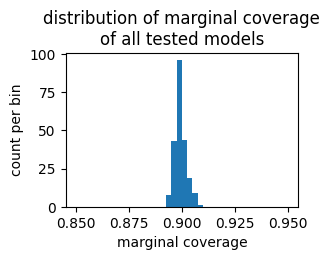

(0.8993966812070692, 0.0027217274446204136)

In [88]:
fig,ax = plt.subplots(figsize=(3,2))
ax.hist(data, range=(0.85,0.95), bins=40)
ax.set(xlabel="marginal coverage", ylabel="count per bin", title="distribution of marginal coverage\nof all tested models")
plt.savefig("plots/marginal_coverage.png", dpi=300, bbox_inches='tight')
plt.show()
np.array(data).mean(), np.array(data).std()

# compare interval sizes

In [89]:
data = []
cols = ['min', 'max', 'mean', 'std', 'median', 'q0.75', 'r_min', 'r_max', 'r_mean', 'r_std', 'r_median', 'r_q0.75']
for label in all_res:
    data.append([])
    for cv in range(1,6):
        interval_sizes = all_res[label][cv]['intervals'][:,1] - all_res[label][cv]['intervals'][:,0]
        interval_sizes_rnd = all_res[label][cv]['rnd_intervals'][:,1] - all_res[label][cv]['rnd_intervals'][:,0]
        data[-1].append((interval_sizes.min(), 
                         interval_sizes.max(), 
                         interval_sizes.mean(),
                         interval_sizes.std(),
                         np.median(interval_sizes), 
                         np.quantile(interval_sizes, 0.75),
                         interval_sizes_rnd.min(), 
                         interval_sizes_rnd.max(), 
                         interval_sizes_rnd.mean(),
                         interval_sizes_rnd.std(),
                         np.median(interval_sizes_rnd), 
                         np.quantile(interval_sizes_rnd, 0.75)))
    data[-1] = np.array(data[-1]).mean(axis=0)
isd = pd.DataFrame(data, columns=cols, index=list(all_res.keys())).sort_values(['mean'])
isd

,min,max,mean,std,median,q0.75,r_min,r_max,r_mean,r_std,r_median,r_q0.75
PRT_med_:2,3.751578,112.826579,7.061167,6.125617,5.992139,7.347911,4.923968,113.998970,8.233558,6.125617,7.164529,8.520303
PRT_sel10_:2,4.203239,117.480042,7.647492,6.620826,6.432317,7.919183,5.564144,118.840941,9.008395,6.620826,7.793217,9.280089
PRT_med_<-2>:<-1>:2,2.203234,151.331375,8.183146,4.102639,7.461505,8.717311,2.977460,152.105606,8.957372,4.102639,8.235730,9.491539
PRT_sel10_<-2>:<-1>:2,3.132456,142.868817,8.209454,4.747388,7.449973,8.656436,3.986334,143.722702,9.063335,4.747388,8.303854,9.510314
PRT_sel10_<-1>:64:2,1.214614,101.749719,8.396183,3.198333,7.916989,8.844350,1.797800,102.332904,8.979370,3.198333,8.500173,9.427537
PRT_med_<-1>:64:2,4.170828,71.030132,8.426553,2.499725,8.012407,9.072192,4.675387,71.534689,8.931114,2.499725,8.516965,9.576749
PRT_med_<-1>:2,3.745015,38.840216,8.444383,1.480622,8.112614,9.035976,4.095467,39.190672,8.794835,1.480622,8.463065,9.386428
PRT_sel10_<-1>:2,-0.208186,89.086421,8.498476,2.487526,8.083219,9.065670,0.258536,89.553143,8.965198,2.487526,8.549941,9.532394
PRT_med_n=100,2.836675,149.920984,9.126328,4.991206,8.348920,10.719057,3.163458,167.477740,10.183310,5.567285,9.316090,11.959502
PRT_sel10_n=100,2.795057,112.991486,9.134474,4.135983,8.336765,10.940296,3.094913,124.990073,10.110187,4.577644,9.227303,12.108837


In [90]:
data = []
for label in all_res:
    data.append(all_res[label][1]['intervals'][:,1] - all_res[label][1]['intervals'][:,0])

[(0.4, 22.6),
 (0.0, 150.0),
 Text(0.5, 1.0, 'Violin plots of conformalized prediction interval sizes'),
 Text(0, 0.5, 'interval size / s')]

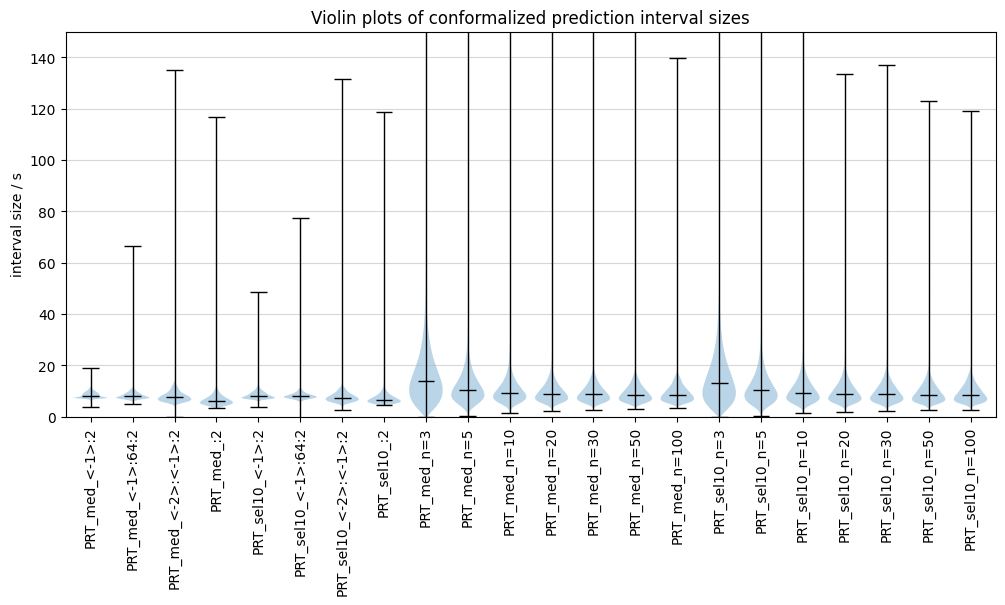

In [91]:
# comparison of interval sizes by violinplots
fig,ax = plt.subplots(figsize=(12, 5))
ax.grid(alpha=0.5, axis='y')
violin = ax.violinplot(data, showmedians=True, vert=True, widths=0.8, points=200)
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
    vp = violin[partname]
    vp.set_edgecolor("black")
    vp.set_linewidth(1)
labels = list(all_res.keys())
ax.set_xticks(range(1,len(labels)+1))
ax.set_xticklabels(labels, rotation=90)
ax.set(xlim=(0.4, len(labels)+0.6),
       ylim=(0,150),
       title='Violin plots of conformalized prediction interval sizes',
       ylabel='interval size / s')

In [92]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity

PRT_med_:2 1019 0.00896005346135922
PRT_sel10_:2 0 0.0
PRT_med_<-1>:64:2 0 0.0
PRT_sel10_<-1>:64:2 9 7.913688042417368e-05
PRT_med_<-1>:2 25 0.00021982466784492688
PRT_sel10_<-1>:2 6 5.275792028278245e-05
PRT_med_<-2>:<-1>:2 29 0.0002549966147001152
PRT_sel10_<-2>:<-1>:2 5 4.396493356898538e-05
PRT_med_n=100 886 0.007790586228424209
PRT_sel10_n=100 1804 0.015862548031689926
PRT_med_n=5 7228 0.06355570796732526
PRT_sel10_n=5 7580 0.06665083929058183


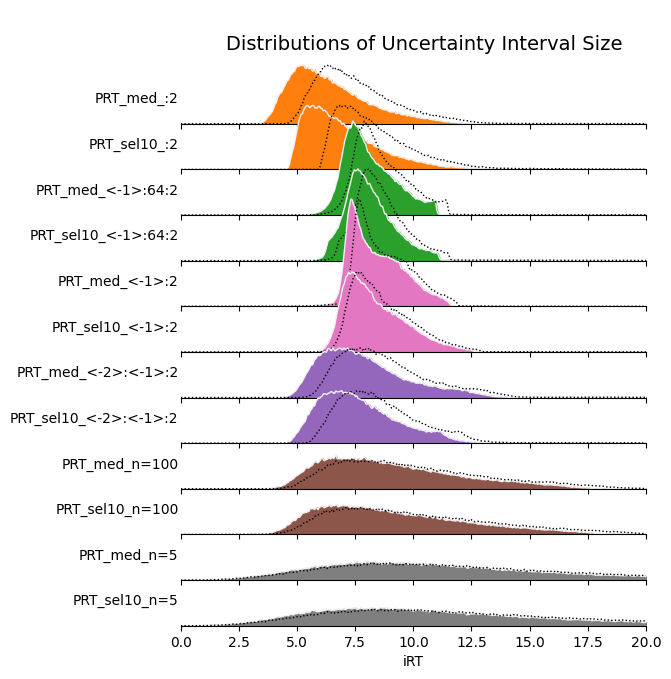

In [33]:
selected_models = ['PRT_med_:2',
                   'PRT_sel10_:2',
                   'PRT_med_<-1>:64:2',
                   'PRT_sel10_<-1>:64:2',
                   'PRT_med_<-1>:2',
                   'PRT_sel10_<-1>:2',
                   'PRT_med_<-2>:<-1>:2',
                   'PRT_sel10_<-2>:<-1>:2',
                   'PRT_med_n=100',
                   'PRT_sel10_n=100',
                   'PRT_med_n=5',
                   'PRT_sel10_n=5',
                   ]
linestyles = {label:"solid" if "med" in label else "dashed" for label in selected_models}
colors = {':2' : "C1", 
          '<-1>:32:2': "C2", '<-1>:64:2': "C2",
          '<-1>:2':'C6',
          '<-2>:<-1>:2':'C4',
          'n=300':"C5", 'n=400':"C5",
          'n=100':"C5",
          'n=5':"C7"}
colors = {label:colors[label.split('_')[-1]] for label in selected_models}
#countries = [x for x in np.unique(data.country)]
#colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(selected_models),1)
fig = plt.figure(figsize=(6,8))

i = 0

ax_objs = []
for label in selected_models:
    x = all_res[label][1]['intervals'][:,1] - all_res[label][1]['intervals'][:,0]
    x_d = np.linspace(0,20, 1000)
    #x_d = x_d[(x_d>=x.min()) & (x_d <= x.max())]

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[label])
    
    # random_model
    x = all_res[label][1]['rnd_intervals'][:,1] - all_res[label][1]['rnd_intervals'][:,0]
    print(label, (x < 5.).sum(), (x < 5.).sum() / (x >= 0).sum())
    x_d = np.linspace(0,20, 1000)
    #x_d = x_d[(x_d>=x.min()) & (x_d <= x.max())]
    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])
    logprob = kde.score_samples(x_d[:, None])
    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="black",lw=1,linestyle="dotted")
    #ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[label])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,20)
    ax_objs[-1].set_ylim(0,.55)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])

    if i == len(selected_models)-1:
        ax_objs[-1].set_xlabel("iRT")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    #adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-0.1,0.1,label,ha="right")


    i += 1

gs.update(hspace=-0.6)

fig.text(0.2,.83,"Distributions of Uncertainty Interval Size",fontsize=14)

#plt.tight_layout()
plt.savefig("plots/uncertainty_interval_sizes_with_rnd.png", dpi=300, bbox_inches='tight')
plt.show()

## set selected models and colors

for all following analyses

In [122]:
selected_models = ['PRT_med_:2',
                   'PRT_sel10_:2',
                   'PRT_med_<-1>:64:2',
                   'PRT_sel10_<-1>:64:2',
                   'PRT_med_<-1>:2',
                   'PRT_sel10_<-1>:2',
                   'PRT_med_<-2>:<-1>:2',
                   'PRT_sel10_<-2>:<-1>:2',
                   'PRT_med_n=100',
                   'PRT_sel10_n=100',
                   ]
linestyles = {label:"solid" if "med" in label else "dashed" for label in selected_models}
colors = {':2' : "C1", 
          '<-1>:32:2': "C2", '<-1>:64:2': "C2",
          '<-1>:2':'C6',
          '<-2>:<-1>:2':'C4',
          'n=300':"C5", 'n=400':"C5",
          'n=100':"C5"}
colors = {label:colors[label.split('_')[-1]] for label in selected_models}

# Evaluating Adaptivity : Conditional coverage

In [41]:
def create_groups(feature, bins, feature_range=None):
    bin_edges = np.histogram_bin_edges(feature, bins=bins, range=feature_range)
    bin_indices = []
    bin_counts = []
    for lower in range(len(bin_edges)-1):
        indices = np.where((bin_edges[lower] <= feature) & (feature < bin_edges[lower+1]))
        bin_indices.append(indices[0])
        bin_counts.append(len(indices[0]))
    return bin_edges, bin_indices, bin_counts

def conditional_coverages(intervals, test_targets, groups):
    cond_covs = []
    for grp in groups:
        within = (test_targets[grp] >= intervals[grp][:,0]) & (test_targets[grp] <= intervals[grp][:,1])
        if len(within):
            cond_covs.append(sum(within) / len(within))
        else:
            cond_covs.append(np.nan)
    return np.array(cond_covs)

In [57]:
def plot_cond_covs(feature, xlabel="", mask=None, bins=10, feature_range=None, errorbars=False, 
                   plot_interval_sizes=False, ylim=(0.8, .95), logscale=False,
                   same_interval_size=True, third_plot=None, random_models=False,
                   savepath=None, axs=None, legend=True):
    if random_models:
        rnd = "rnd_"
    else:
        rnd = ""
    if mask is None:
        mask = np.full((len(test_targets),), True)
    if len(feature.shape) == 1:
        bin_edges, bin_indices, bin_counts = create_groups(feature[mask], bins=bins, feature_range=feature_range)
        bin_centers = bin_edges[1:] - (bin_edges[1:] - bin_edges[:-1]) / 2
    else:
        bin_counts_avg = []
            
    if third_plot is None:
        if axs:
            ax1,ax2 = axs
        else:
            fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,4), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5], 'hspace':0.07})
        ax_xl = ax2
    else:
        if axs:
            ax1,ax2,ax3 = axs
        else:
            fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,7), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5, 2.5], 'hspace':0.07})
        ax_xl = ax3
    ax2.axhline(0.9, color='black', linewidth=1, alpha=0.5)
    for i,label in enumerate(selected_models):
        if len(feature.shape) > 1:
            bin_edges, bin_indices, bin_counts = [], [], []
            for cv in range(5):
                bin_edges, bin_indices_, bin_counts_ = create_groups(feature[i][cv][mask], bins=bins, feature_range=feature_range)
                bin_indices.append(bin_indices_)
                bin_counts.append(bin_counts_)
            bin_centers = bin_edges[1:] - (bin_edges[1:] - bin_edges[:-1]) / 2
            bin_counts_avg.append(np.mean(bin_counts, axis=0))
        cond_covs = []
        for cv in range(1,5):
            intervals = all_res[label][cv][rnd + 'intervals']
            if len(feature.shape) > 1:
                cond_covs.append(conditional_coverages(intervals[mask], test_targets[mask], bin_indices[cv-1]))
            else:
                cond_covs.append(conditional_coverages(intervals[mask], test_targets[mask], bin_indices))
        cond_covs = np.column_stack(cond_covs)
        cond_covs = np.mean(cond_covs, axis=1), np.std(cond_covs, axis=1)
        if same_interval_size:
            X = np.arange(0., len(bin_centers)) + 0.5
        else:
            X = bin_centers
        if errorbars:
            ax2.errorbar(X, cond_covs[0], yerr=cond_covs[1], label=label, color=colors[label], linestyle=linestyles[label])
        else:
            ax2.plot(X, cond_covs[0], label=label, color=colors[label], linestyle=linestyles[label])
    if legend:
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if same_interval_size:
        width = 0.5
    else:
        width = (bin_centers[1]-bin_centers[0]) / 2
    if len(feature.shape) > 1:
        bin_counts = np.array(bin_counts_avg)
        ax1.bar(X, np.mean(bin_counts, axis=0), color='gray', yerr=np.std(bin_counts_avg, axis=0), width=width)
    else:
        ax1.bar(X, bin_counts, color='gray', width=width)
    ax1.set(ylabel="data count")
    if logscale:
        ax1.set_yscale("log")
    ax2.set(ylim=ylim, ylabel="conditional coverage")
    ax_xl.set_xlabel(xlabel)
    if same_interval_size:
        ax_xl.set(xlim=(0, len(bin_edges)-1))
        ax_xl.set_xticks(np.arange(0, len(bin_edges)))
        ax_xl.set_xticklabels([f"{v}" for v in bin_edges])
    else:
        ax_xl.set(xlim=(bin_edges[0], bin_edges[-1]))
        ax_xl.set_xticks(bin_edges)
    ax2.grid(alpha=0.5, axis="x")
    
    if third_plot is not None:
        ax3.grid(alpha=0.5, axis="x")
        if len(third_plot['data'].shape) > 2:
            for i,label in enumerate(selected_models):
                data = []
                for ind in bin_indices:
                    data.append((np.mean(third_plot['data'][i,:,mask][ind], axis=1).mean(), 
                                 np.mean(third_plot['data'][i,:,mask][ind], axis=1).std()))
                data = np.array(data)
                if errorbars:
                    ax3.errorbar(X, data[:,0], yerr=data[:,1], label=label, color=colors[label], linestyle=linestyles[label])
                else:
                    ax3.plot(X, data[:,0], label=label, color=colors[label], linestyle=linestyles[label])
        ax_params = {key:val for key,val in third_plot.items() if key != "data"}
        ax3.set(**ax_params)
    if not axs:
        if savepath is not None:
            plt.savefig(savepath, dpi=300, bbox_inches='tight')
        plt.show()

## Feature-stratified coverage

### Sequence length

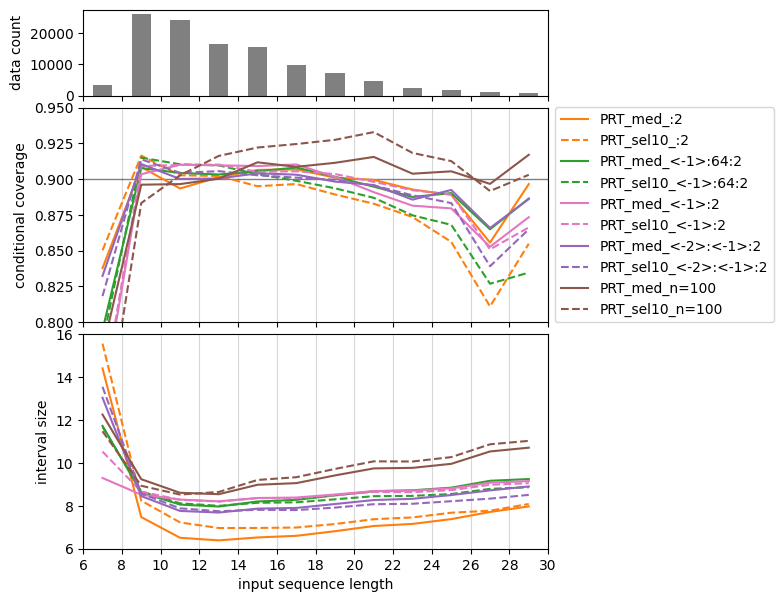

In [44]:
seq_lens = test_data_stats.modified_sequence_single_letter.str.len().to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(seq_lens, xlabel="input sequence length", bins=list(range(6,31,2)),
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6,16)},
               savepath="plots/seq_len.png")

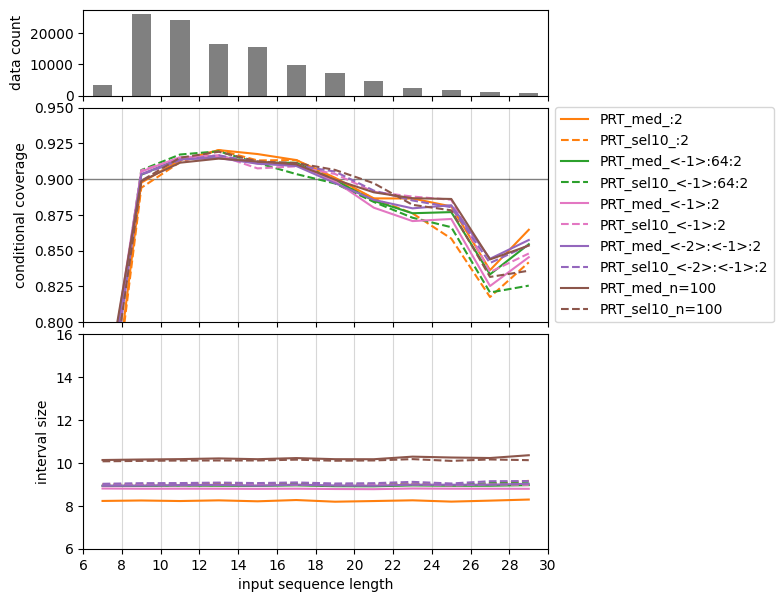

In [45]:
seq_lens = test_data_stats.modified_sequence_single_letter.str.len().to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(seq_lens, xlabel="input sequence length", bins=list(range(6,31,2)), random_models=True, 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6,16)},
               savepath="plots/seq_len_rnd.png")

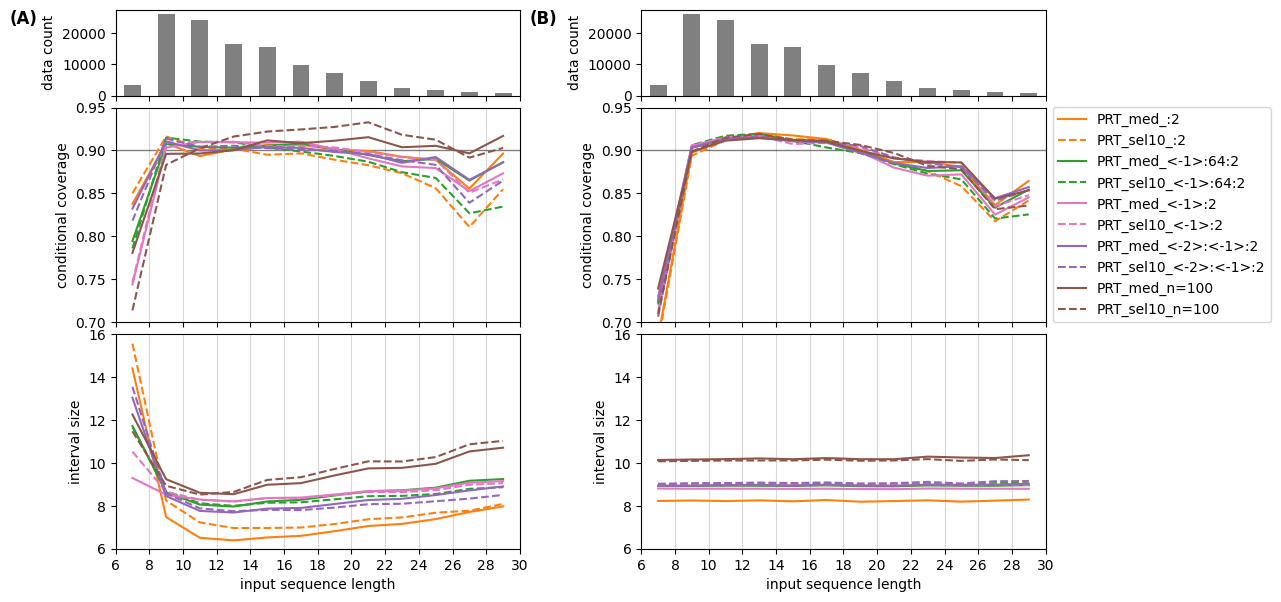

In [123]:
fig,((ax1_1,ax1_2),(ax2_1,ax2_2),(ax3_1,ax3_2)) = plt.subplots(ncols=2,nrows=3,figsize=(12,7), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5, 2.5], 'hspace':0.07, 'wspace':0.3})
# not random
seq_lens = test_data_stats.modified_sequence_single_letter.str.len().to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(seq_lens, xlabel="input sequence length", bins=list(range(6,31,2)),
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6,16)}, ylim=(0.7, .95),
               axs=(ax1_1,ax2_1,ax3_1), legend=False)
# random
seq_lens = test_data_stats.modified_sequence_single_letter.str.len().to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(seq_lens, xlabel="input sequence length", bins=list(range(6,31,2)), ylim=(0.7, .95), random_models=True, 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6,16)},
               axs=(ax1_2,ax2_2,ax3_2), legend=True)
# layout
plt.text(0.037, 0.86, '(A)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.text(0.47, 0.86, '(B)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.savefig("plots/seq_len_both.png", dpi=300, bbox_inches='tight')
plt.show()

### Target std. deviation

In [180]:
# We have to look at targets with >=50 cnts! Otherwise the variance of std. dev. is too high.

In [ ]:
fig,ax = plt.subplots()
ax.scatter()

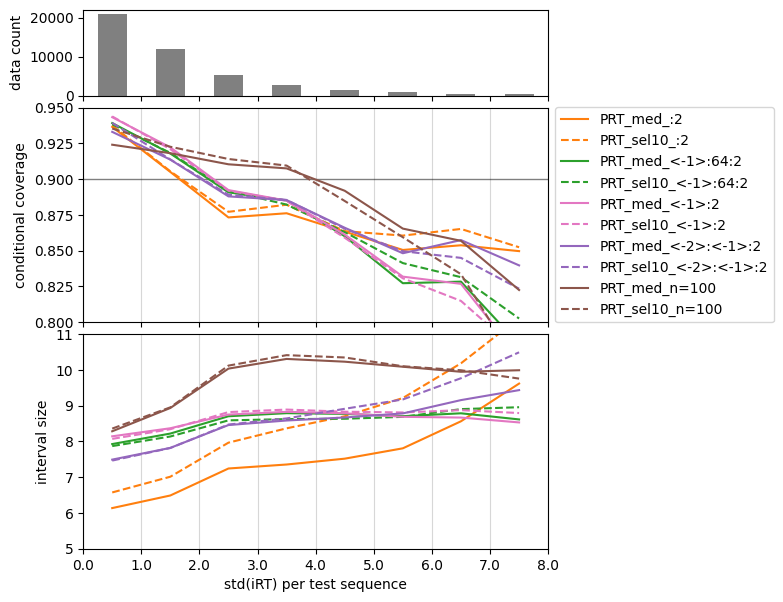

In [99]:
target_stds = test_data_stats['std'].to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(target_stds, xlabel="std(iRT) per test sequence", mask=(test_data_stats['cnt'] >= 50), 
               bins=np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.]),
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(5,11)},
               savepath="plots/std.png")

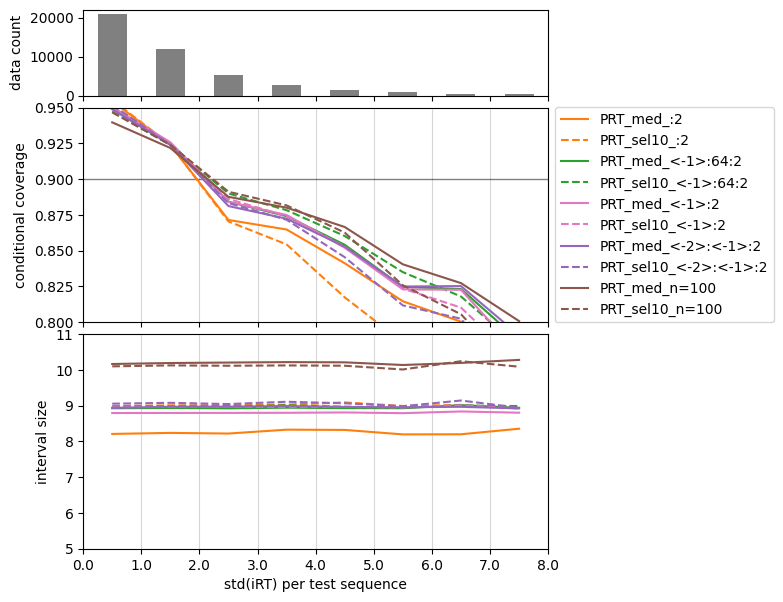

In [100]:
target_stds = test_data_stats['std'].to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(target_stds, xlabel="std(iRT) per test sequence", mask=(test_data_stats['cnt'] >= 50),
               bins=np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.]),
               random_models=True,
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(5,11)},
               savepath="plots/std_rnd.png")

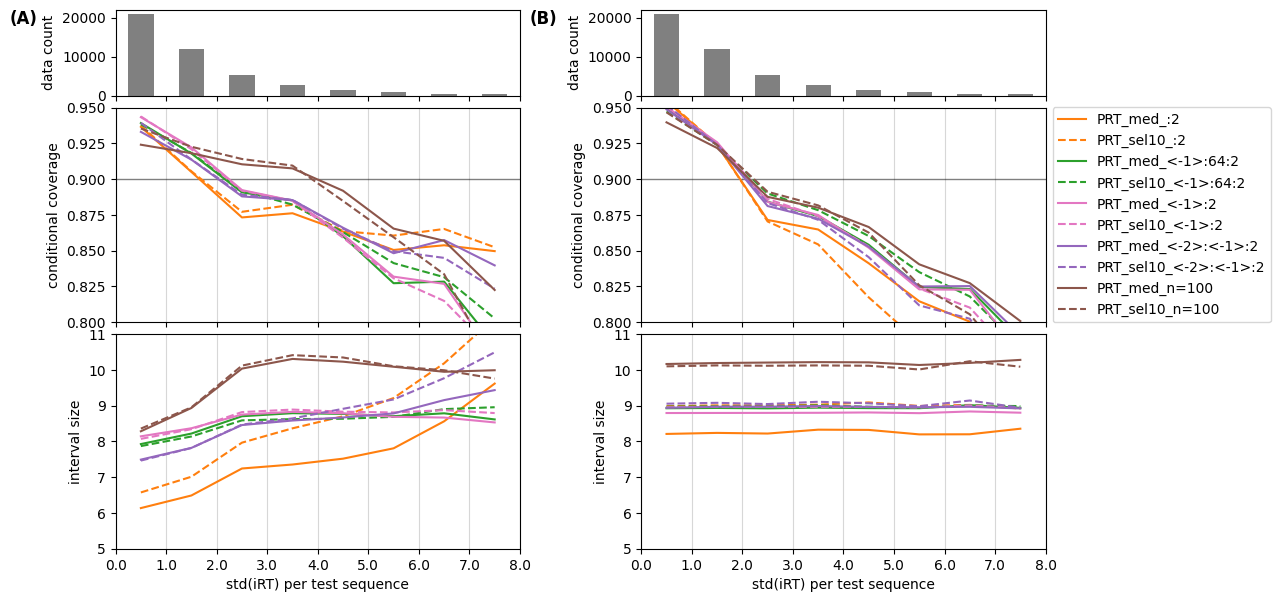

In [101]:
fig,((ax1_1,ax1_2),(ax2_1,ax2_2),(ax3_1,ax3_2)) = plt.subplots(ncols=2,nrows=3,figsize=(12,7), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5, 2.5], 'hspace':0.07, 'wspace':0.3})
# not random
target_stds = test_data_stats['std'].to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(target_stds, xlabel="std(iRT) per test sequence", mask=(test_data_stats['cnt'] >= 50), 
               bins=np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.]),
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(5,11)},
               axs=(ax1_1,ax2_1,ax3_1), legend=False)
# random
target_stds = test_data_stats['std'].to_numpy()
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(target_stds, xlabel="std(iRT) per test sequence", mask=(test_data_stats['cnt'] >= 50),
               bins=np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.]),
               random_models=True,
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(5,11)},
               axs=(ax1_2,ax2_2,ax3_2), legend=True)
# layout
plt.text(0.037, 0.86, '(A)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.text(0.47, 0.86, '(B)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.savefig("plots/std_both.png", dpi=300, bbox_inches='tight')
plt.show()

## Number of data points

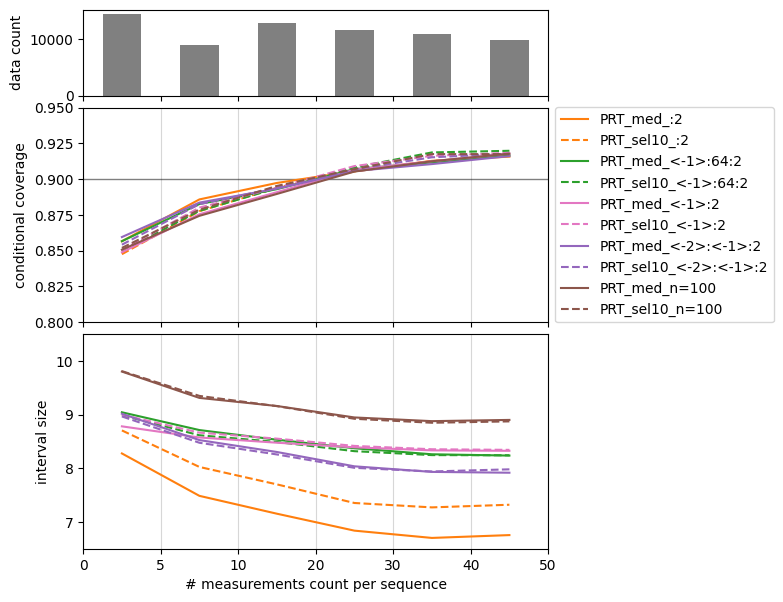

In [102]:
cnts = test_data_stats['cnt'].to_numpy()
#plot_cond_covs(cnts, bins=np.arange(0.,500.,50.))
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(cnts, xlabel="# measurements count per sequence", bins=[0,5,10,20,30,40,50], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)},
               savepath="plots/cnt.png")

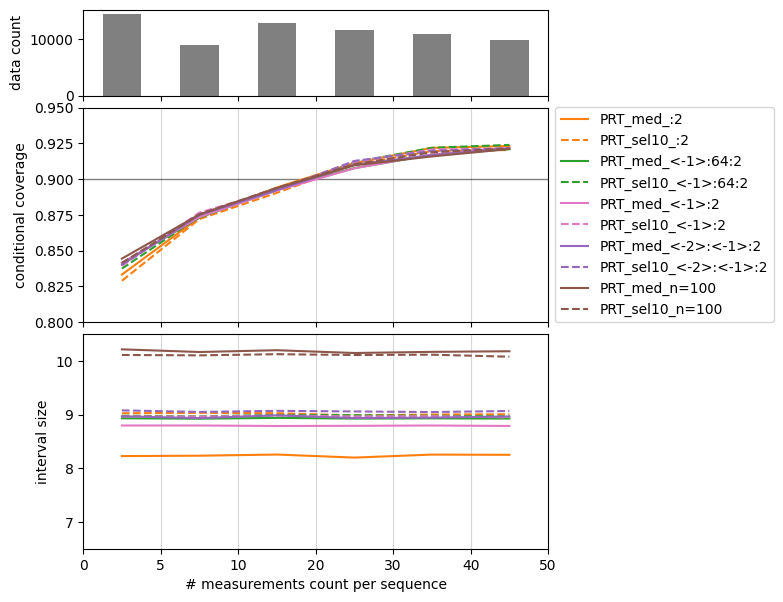

In [103]:
cnts = test_data_stats['cnt'].to_numpy()
#plot_cond_covs(cnts, bins=np.arange(0.,500.,50.))
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(cnts, xlabel="# measurements count per sequence", bins=[0,5,10,20,30,40,50], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)}, random_models=True,
               savepath="plots/cnt_rnd.png")

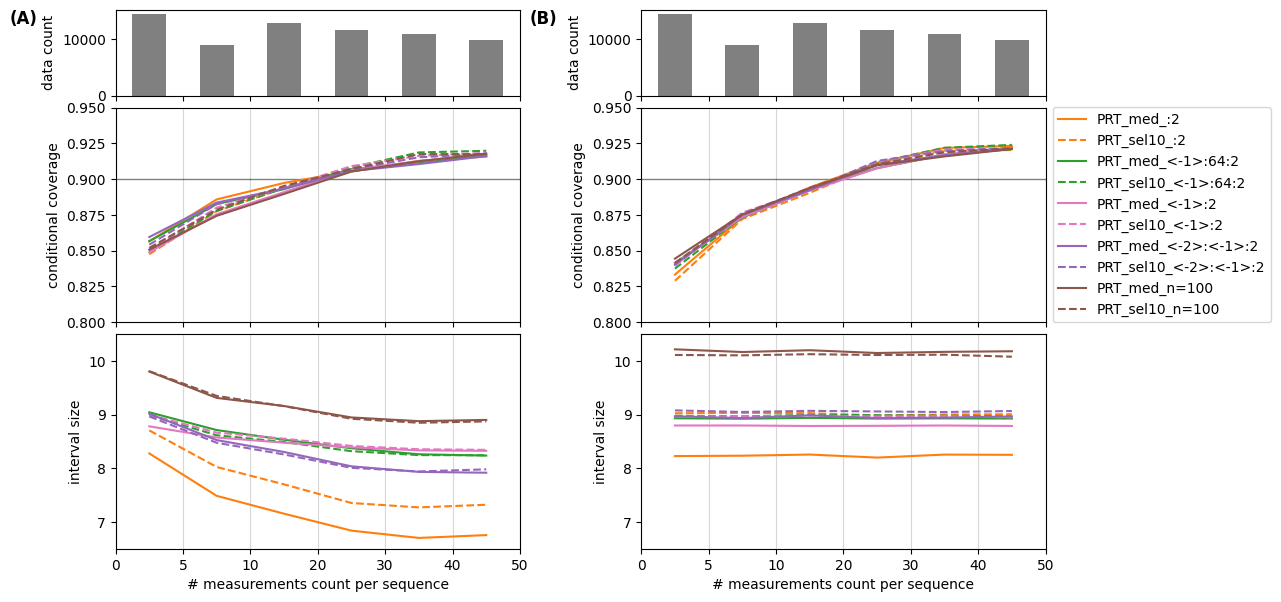

In [104]:
fig,((ax1_1,ax1_2),(ax2_1,ax2_2),(ax3_1,ax3_2)) = plt.subplots(ncols=2,nrows=3,figsize=(12,7), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5, 2.5], 'hspace':0.07, 'wspace':0.3})
# not random
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(cnts, xlabel="# measurements count per sequence", bins=[0,5,10,20,30,40,50], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)},
               axs=(ax1_1,ax2_1,ax3_1), legend=False)
# random
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(cnts, xlabel="# measurements count per sequence", bins=[0,5,10,20,30,40,50], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)}, random_models=True,
               axs=(ax1_2,ax2_2,ax3_2), legend=True)
# layout
plt.text(0.037, 0.86, '(A)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.text(0.47, 0.86, '(B)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.savefig("plots/cnt_both.png", dpi=300, bbox_inches='tight')
plt.show()

## Mean Andromeda score

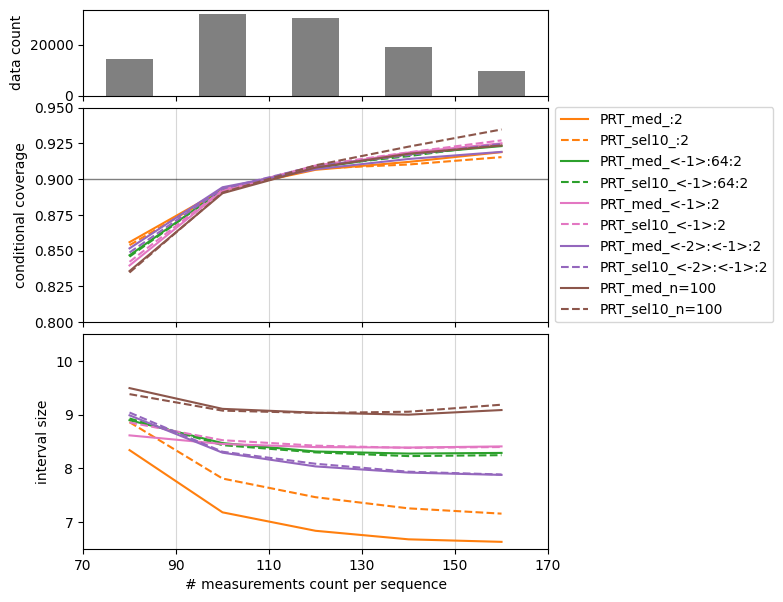

In [105]:
X = test_data_stats['mean_andromeda'].to_numpy()
#plot_cond_covs(cnts, bins=np.arange(0.,500.,50.))
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(X, xlabel="# measurements count per sequence", bins=[70,90,110,130,150,170], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)},
               savepath=None)

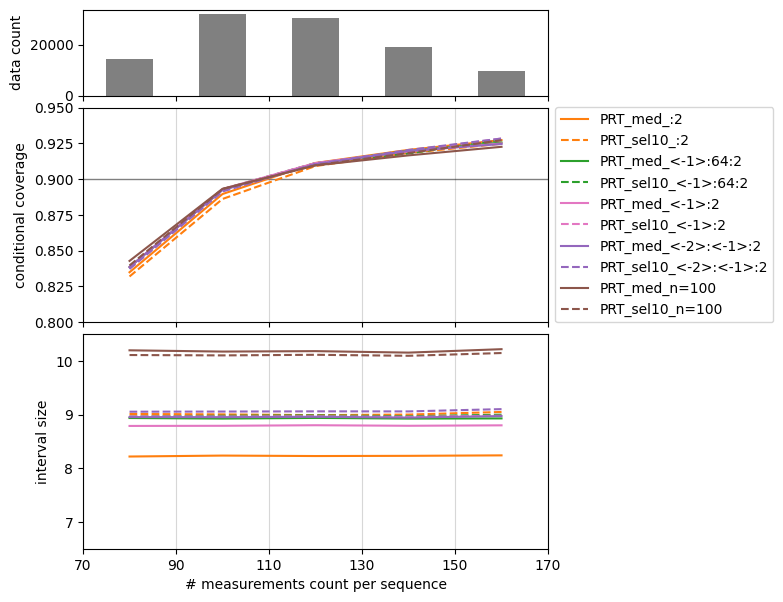

In [106]:
X = test_data_stats['mean_andromeda'].to_numpy()
#plot_cond_covs(cnts, bins=np.arange(0.,500.,50.))
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(X, xlabel="# measurements count per sequence", bins=[70,90,110,130,150,170], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)}, random_models=True,
               savepath=None)

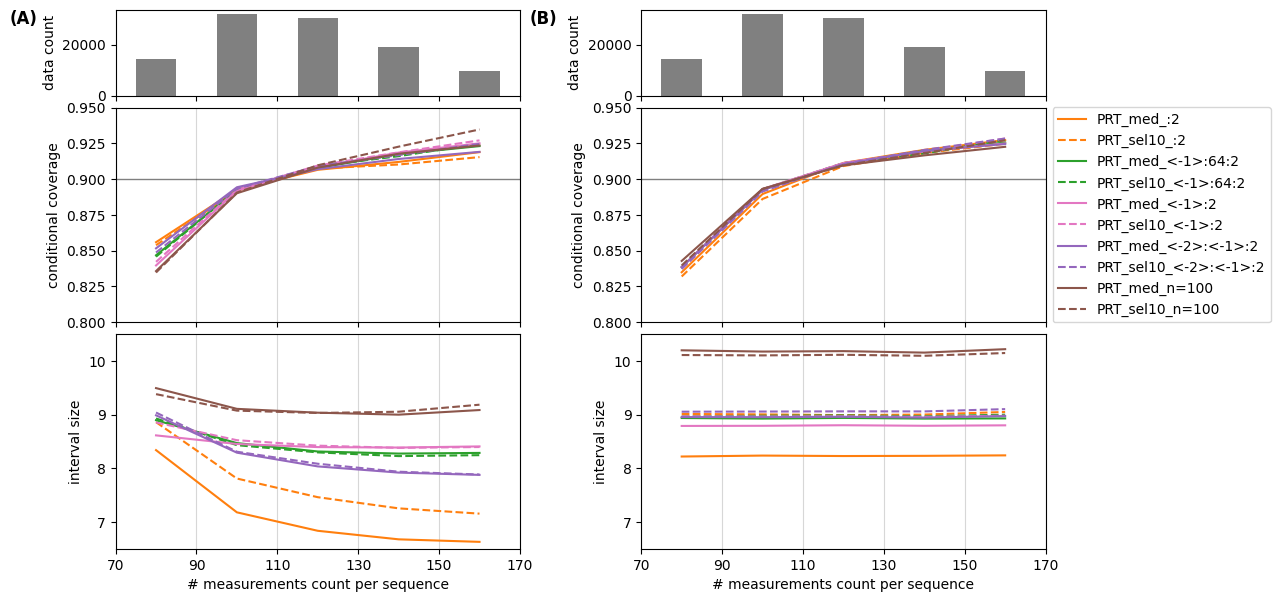

In [107]:
fig,((ax1_1,ax1_2),(ax2_1,ax2_2),(ax3_1,ax3_2)) = plt.subplots(ncols=2,nrows=3,figsize=(12,7), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5, 2.5], 'hspace':0.07, 'wspace':0.3})
# not random
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(X, xlabel="# measurements count per sequence", bins=[70,90,110,130,150,170], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)},
               axs=(ax1_1,ax2_1,ax3_1), legend=False)
# random
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
interval_sizes = np.array(interval_sizes)
plot_cond_covs(X, xlabel="# measurements count per sequence", bins=[70,90,110,130,150,170], 
               third_plot={'data':interval_sizes, 'ylabel':"interval size", "ylim":(6.5,10.5)}, random_models=True,
               axs=(ax1_2,ax2_2,ax3_2), legend=True)
# layout
plt.text(0.037, 0.86, '(A)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.text(0.47, 0.86, '(B)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.savefig("plots/andromeda_both.png", dpi=300, bbox_inches='tight')
plt.show()

## Size-stratisfied coverage

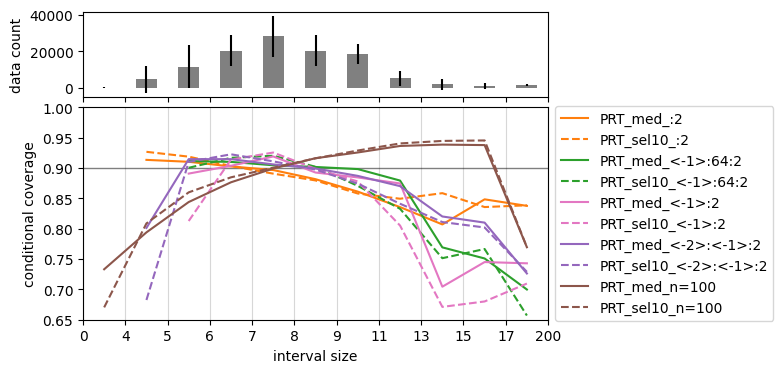

In [108]:
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
plot_cond_covs(np.array(interval_sizes), xlabel="interval size",
               bins=[0,4,5,6,7,8,9,11,13,15,17,200], ylim=(0.65,1.), logscale=False,
               savepath="plots/int_size.png")

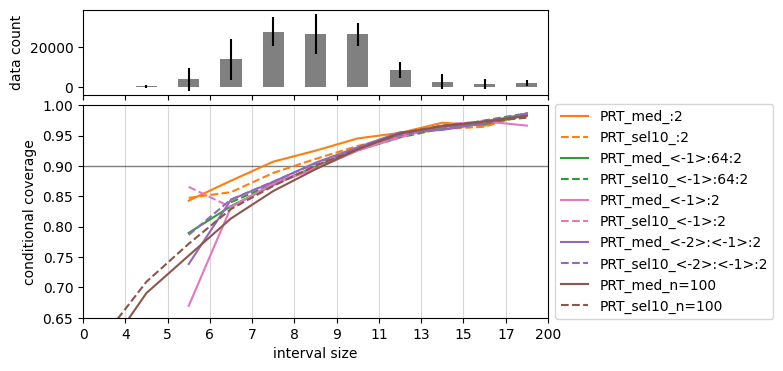

In [109]:
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
plot_cond_covs(np.array(interval_sizes), xlabel="interval size",
               bins=[0,4,5,6,7,8,9,11,13,15,17,200], ylim=(0.65,1.), logscale=False, 
               random_models=True,
               savepath="plots/int_size_rnd.png")

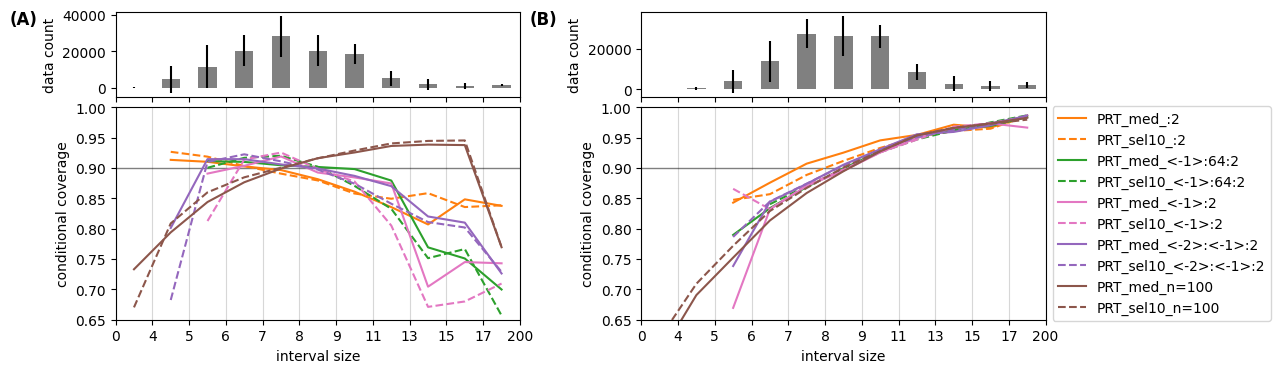

In [114]:
fig,((ax1_1,ax1_2),(ax2_1,ax2_2)) = plt.subplots(ncols=2,nrows=2,figsize=(12,4), sharex=True, 
                                     gridspec_kw={'height_ratios': [1, 2.5], 'hspace':0.07, 'wspace':0.3})
# not random
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
plot_cond_covs(np.array(interval_sizes), xlabel="interval size",
               bins=[0,4,5,6,7,8,9,11,13,15,17,200], ylim=(0.65,1.), logscale=False,
               axs=(ax1_1,ax2_1), legend=False)
# random
interval_sizes = []
for label in selected_models:
    interval_sizes.append([])
    for cv in range(1,6):
        intervals = all_res[label][cv]['rnd_intervals']
        interval_sizes[-1].append(intervals[:,1] - intervals[:,0])
plot_cond_covs(np.array(interval_sizes), xlabel="interval size",
               bins=[0,4,5,6,7,8,9,11,13,15,17,200], ylim=(0.65,1.), logscale=False, random_models=True,
               axs=(ax1_2,ax2_2), legend=True)
# layout
plt.text(0.037, 0.85, '(A)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.text(0.47, 0.85, '(B)', fontweight='bold', fontsize=12, transform=fig.transFigure)
plt.savefig("plots/int_size_both.png", dpi=300, bbox_inches='tight')
plt.show()